In [1]:
using Random

In [2]:
include("../rollout.jl")

simulate_trajectory (generic function with 1 method)

In [3]:
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

In [4]:
HORIZON = 0
MC_SAMPLES = 25
BUDGET = 15
NUM_TRIALS = 10
MAX_SGD_ITERS = 100
BATCH_SIZE = 8

8

In [5]:
# Setup toy problem using synthetic test function
# testfn = TestAckley(1)
testfn = TestGramacyLee()
fbest = testfn.f(first(testfn.xopt))
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]
initial_samples = randsample(NUM_TRIALS, testfn.dim, lbs, ubs)
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1)
batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs);

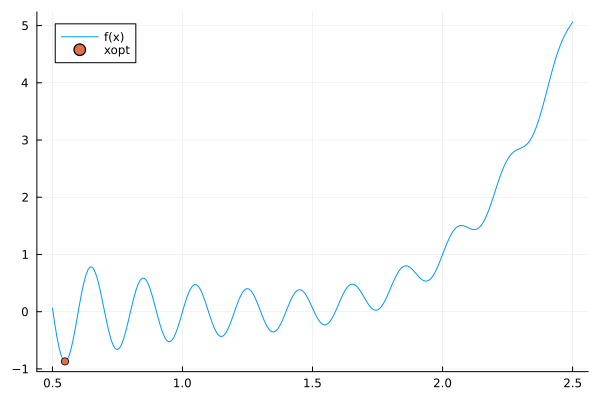

In [6]:
tplot(testfn)

In [7]:
# Setup Gaussian Process statistical model
ℓ, output_variance, σn2 = [1.], 1., 1e-8
ψ = kernel_scale(kernel_matern52, [output_variance, ℓ...]);

In [8]:
X = reshape(initial_samples[:, 1], testfn.dim, 1)
X = reshape(X, testfn.dim, length(X))
sur = fit_surrogate(ψ, X, testfn.f; σn2=σn2);

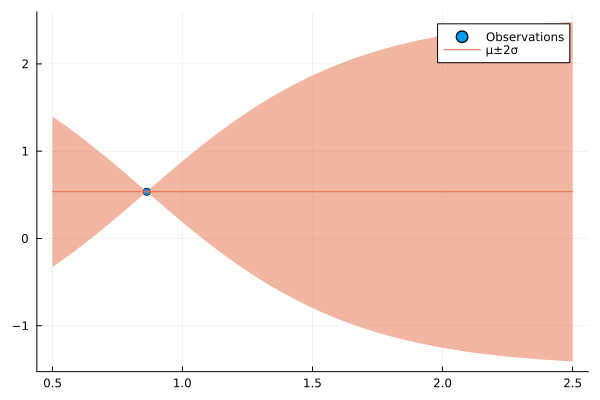

In [9]:
plot1D(sur; domain=lbs[1]:.01:ubs[1])

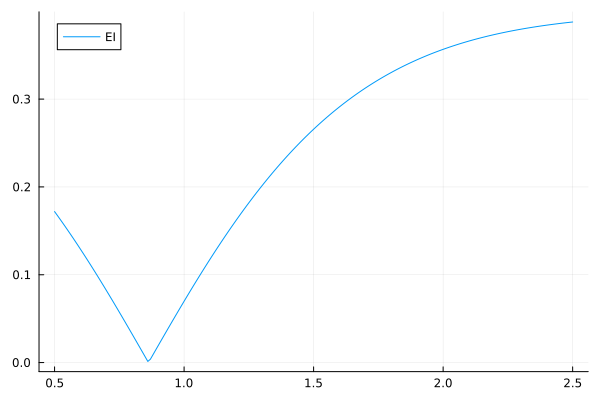

In [10]:
plot1DEI(sur; domain=lbs[1]:.01:ubs[1])

In [11]:
gaps = []
sur = nothing

for trial in 1:NUM_TRIALS
    println("Starting Trial #$trial")
    # Grab initial sample for each trial
    X = reshape(initial_samples[:, trial], testfn.dim, 1)
    sur = fit_surrogate(ψ, X, testfn.f; σn2=σn2)
    result = optimize_hypers_optim(sur, kernel_matern52; σn2=σn2)
    σf, ℓ = Optim.minimizer(result)
    ψ = kernel_scale(kernel_matern52, [σf, ℓ])
    sur = fit_surrogate(ψ, X, testfn.f; σn2=σn2)
    
    println("Beginning Bayesian Optimization Main Loop")
    println("-----------------------------------------")
    for budget in 1:BUDGET
        println("Iteration #$budget")
        results = []
        
        # Evaluate α(x) for each batch location and perform SGA
        for j in 1:size(batch, 2)
            x0 = batch[:, j]
            # try-catch guard for rollout at points sufficiently close to history.
            # These locations produce a singular exception since the expected improvement
            # at these locations is expected to be zero.
            try
                res = stochastic_gradient_ascent_adam(x0;
                    max_sgd_iters=MAX_SGD_ITERS, lbs=lbs, ubs=ubs, mc_iters=MC_SAMPLES,
                    lds_rns=lds_rns, horizon=HORIZON, sur=sur, gtol=1e-10, ftol=1e-8, max_counter=10
                )
                push!(results, res)
            catch e
                # println(e)
                # println("$x0 too close to point in $(sur.X)")
                continue
            end
        end # END for j in batch
        # for r in results
        #     println("Begin: $(r.start) -- End: $(r.finish) -- Func: $(r.final_obj) -- Grad: $(first(r.final_grad)) -- Iters: $(r.iters)")
        # end
        
        if length(results) == 0
            start = finish = rand(testfn.dim) .* (ubs - lbs) + lbs
            push!(results, (start=start, finish=finish, final_obj=nothing, final_grad=nothing, iters=0))
        end
        
        # Grab the location with best function evaluation
        best_j = findmax(t -> t.final_obj, results)[2]
        best_result = results[best_j]
        # println("Selected Location: $(best_result.finish)")
        
        # Update model at best location
        sur = update_surrogate(sur, best_result.finish, testfn.f)
        res = optimize_hypers_optim(sur, kernel_matern52; σn2=σn2)
        σ, ℓ = Optim.minimizer(res)
        ψ = kernel_scale(kernel_matern52, [σ, ℓ])
        sur = fit_surrogate(ψ, sur.X, recover_y(sur); σn2=σn2)
        # println("Optimal Kernel Hyperparameters: ($σ, $ℓ)")
    end # END for budget iterations
    
    push!(gaps, measure_gap(sur, fbest))
    println("")
end # END for trial iterations

Starting Trial #1
Beginning Bayesian Optimization Main Loop
-----------------------------------------
Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
Iteration #8
Iteration #9
Iteration #10
Iteration #11
Iteration #12
Iteration #13
Iteration #14
Iteration #15

Starting Trial #2
Beginning Bayesian Optimization Main Loop
-----------------------------------------
Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
Iteration #8
Iteration #9
Iteration #10
Iteration #11
Iteration #12
Iteration #13
Iteration #14
Iteration #15

Starting Trial #3
Beginning Bayesian Optimization Main Loop
-----------------------------------------
Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
Iteration #8
Iteration #9
Iteration #10
Iteration #11
Iteration #12
Iteration #13
Iteration #14
Iteration #15

Starting Trial #4
Beginning Bayesian Optimization Main Loop
----------------------------

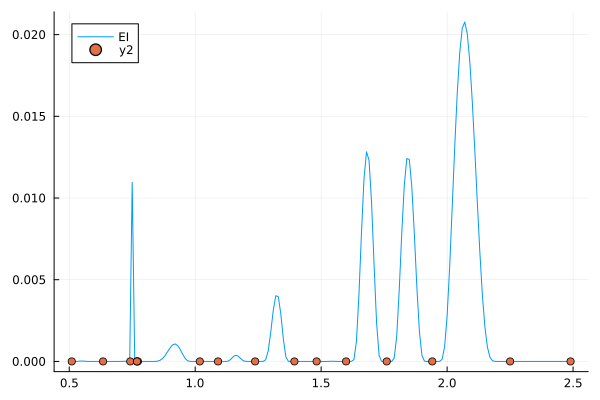

In [12]:
domain = filter(x -> !(x in sur.X), lbs[1]:.01:ubs[1])
plot1DEI(sur; domain=domain)
scatter!(sur.X', 0sur.y)

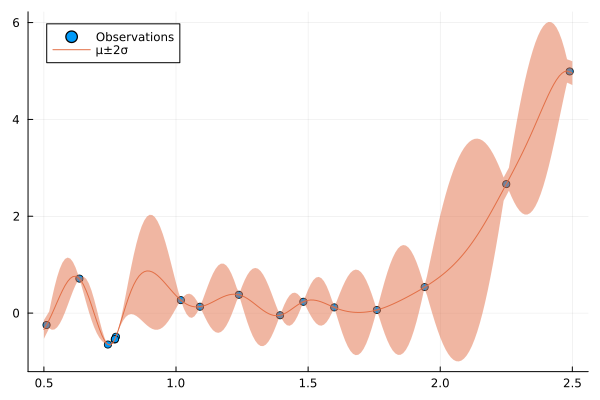

In [13]:
plot1D(sur; domain=domain)

In [14]:
mean_gaps = []

# Iterate across each column
for j in 1:length(gaps[1])
    push!(mean_gaps, 0.)
    
    for i in 1:length(gaps)
        mean_gaps[j] += gaps[i][j]
    end
    
    mean_gaps[j] /= length(gaps)
end

best_gap_ndx = findmax(g -> g[end], gaps)[2]
worse_gap_ndx = findmin(g -> g[end], gaps)[2]
best_gap = gaps[best_gap_ndx]
worst_gap = gaps[worse_gap_ndx];

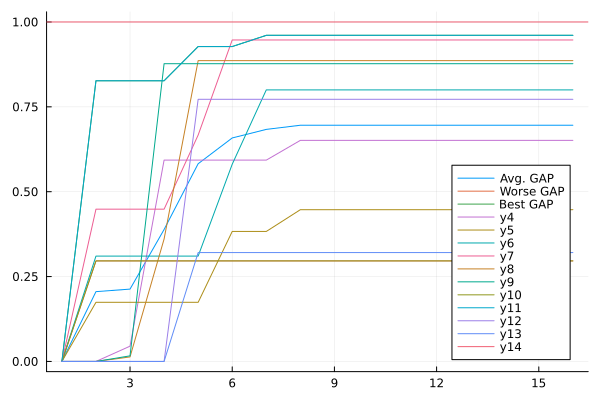

In [16]:
plot(mean_gaps, label="Avg. GAP")
plot!(worst_gap, label="Worse GAP")
plot!(best_gap, label="Best GAP")
hline!([1.])

In [18]:
gaps

10-element Vector{Any}:
 Any[0.0, 0.0, 0.04501732127590645, 0.5930696844431413, 0.5930696844431413, 0.5930696844431413, 0.5930696844431413, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345, 0.651285344370345]
 Any[0.0, 0.1741063801698312, 0.1741063801698312, 0.1741063801698312, 0.1741063801698312, 0.3829304920074364, 0.3829304920074364, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404, 0.44705769152233404]
 Any[0.0, 0.31033947626164865, 0.31033947626164865, 0.31033947626164865, 0.31033947626164865, 0.5809347617157528, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767, 0.8000097874718767]
 Any[0.0, 0.44852929745469217, 0.44852929745469217, 0.44

In [ ]:
λ = .01
grads = 1:1:10^5

plot(
    grads,
    update_λ.(Ref(λ), grads),
    yaxis=:log,
    xaxis=:log,
    xticks=10. .^ (1:5),
    yticks=10. .^ (-2:-1:-7)
)

In [ ]:
10. .^ (-2:-1:-6)

In [ ]:
counter = 0

In [ ]:
counter += 1 < 3

In [ ]:
counter